In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch torchvision

In [3]:
import warnings
warnings.filterwarnings("ignore") 
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import time
from tqdm import tqdm
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from torchvision import models
from torchvision.transforms import transforms
from torchvision.models import resnet18, vgg16
from torch.nn import Linear, CrossEntropyLoss

In [4]:
# importing eurosat data which contains only 5 categories
eurosat_data = '/kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB'
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))
for dirname in os.listdir(eurosat_data):
    print(dirname, len(os.listdir(os.path.join(eurosat_data,dirname))))

categories = os.listdir(eurosat_data)

print(f"Categories: {len(categories)}")

SeaLake 3000
Highway 2500
River 2500
AnnualCrop 3000
Forest 3000
Categories: 5


In [5]:
import random
import shutil


output_path = '/kaggle/working/eurosat-rgb-sample/'
for category in categories:
    category_path = os.path.join(eurosat_data, category)
    
    print(f'category path: {category_path}')
    #print(os.listdir(category_path)[0])
    images = []
    # taking 20 images from the category randomly
    for i in range(20):
        images.append(os.listdir(category_path)[random.randint(0, len(os.listdir(category_path)))])
    
    print(images)
    # splitting the selected 20 images in train and rest
    os.makedirs(os.path.join(output_path, 'train', category), exist_ok=True)
    train, rest = train_test_split(images, test_size=0.75, random_state=0)
    val, test = train_test_split(rest, test_size=0.8, random_state=0)
    
    print(f"train size:{len(train)} ")
    print(f"test size:{len(test)} ")
    print(f"val size:{len(val)} ")
    # saving them separetely under the output path
    os.makedirs(os.path.join(output_path, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'test', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', category), exist_ok=True)
#     os.makedirs(os.path.join(output_path, 'test', category), exist_ok=True)

    for img in train:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'train', category, img))
    for img in test:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'test', category, img))
    for img in val:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'val', category, img))

category path: /kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB/SeaLake
['SeaLake_2620.jpg', 'SeaLake_472.jpg', 'SeaLake_1428.jpg', 'SeaLake_217.jpg', 'SeaLake_460.jpg', 'SeaLake_316.jpg', 'SeaLake_1019.jpg', 'SeaLake_1575.jpg', 'SeaLake_359.jpg', 'SeaLake_645.jpg', 'SeaLake_259.jpg', 'SeaLake_1031.jpg', 'SeaLake_2296.jpg', 'SeaLake_2896.jpg', 'SeaLake_2523.jpg', 'SeaLake_1217.jpg', 'SeaLake_1844.jpg', 'SeaLake_997.jpg', 'SeaLake_949.jpg', 'SeaLake_504.jpg']
train size:5 
test size:12 
val size:3 
category path: /kaggle/input/eurosat-rgb-5-categories/EuroSAT_RGB/Highway
['Highway_1588.jpg', 'Highway_2439.jpg', 'Highway_720.jpg', 'Highway_714.jpg', 'Highway_1490.jpg', 'Highway_879.jpg', 'Highway_1068.jpg', 'Highway_374.jpg', 'Highway_1905.jpg', 'Highway_2444.jpg', 'Highway_1105.jpg', 'Highway_406.jpg', 'Highway_237.jpg', 'Highway_189.jpg', 'Highway_451.jpg', 'Highway_224.jpg', 'Highway_1862.jpg', 'Highway_923.jpg', 'Highway_84.jpg', 'Highway_522.jpg']
train size:5 
test size:12 
val s

In [6]:
from torchvision.datasets import ImageFolder

BATCH_SIZE = 32 
NUM_EPOCHS = 5

train_path = '/kaggle/working/eurosat-rgb-sample/train'
val_path = '/kaggle/working/eurosat-rgb-sample/val'
test_path = '/kaggle/working/eurosat-rgb-sample/testfrom torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [19]:
from transformers import ViTModel, AutoImageProcessor
NUM_CLASSES = len(train_dataset.classes)
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", do_rescale=False)
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
classification_head = nn.Linear(model.config.hidden_size, NUM_CLASSES)
model.load_state_dict(torch.load('//kaggle/input/vit-pretrained-eurosat/vit_model_rmsprop.pth', map_location=device),strict=False)
# Check if multiple GPUs are available
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     # Wrap the model for multi-GPU usage
#     model = nn.DataParallel(model)
model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [20]:
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, classification_head, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS, early_stopping_patience=3):
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    classification_head.to(device)

    loss_fn = CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

    for epoch in range(num_epochs):
        # Training Step
        model.train()
        classification_head.train()
        
        total_loss = 0
        correct_train_predictions = 0
        total_train_samples = 0
        
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for images, labels in train_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            inputs = image_processor(images, return_tensors="pt").to(device)
            outputs = model(**inputs).last_hidden_state
            outputs = outputs[:, 0, :]
            logits = classification_head(outputs)

            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            _, predictions = torch.max(logits, 1)
            correct_train_predictions += (predictions == labels).sum().item()
            total_train_samples += labels.size(0)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Step
        model.eval()
        classification_head.eval()
        
        total_val_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images = images.to(device)
                labels = labels.to(device)

                inputs = image_processor(images, return_tensors="pt").to(device)
                outputs = model(**inputs).last_hidden_state
                outputs = outputs[:, 0, :]
                logits = classification_head(outputs)

                val_loss = loss_fn(logits, labels)
                total_val_loss += val_loss.item()

                _, predictions = torch.max(logits, 1)
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                
                val_progress_bar.set_postfix(loss=val_loss.item())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_predictions / total_samples
        
        scheduler.step(avg_val_loss)
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement in validation loss.")
            break
        
    return train_losses, train_accuracies, val_losses, val_accuracies

def test_model(model, classification_head, test_loader):
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.eval()
    classification_head.eval()

    total_test_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    test_losses = []
    test_accuracies = []

    loss_fn = CrossEntropyLoss()

    test_progress_bar = tqdm(test_loader, desc='Testing')

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            inputs = image_processor(images, return_tensors="pt").to(device)
            outputs = model(**inputs).last_hidden_state
            outputs = outputs[:, 0, :]
            logits = classification_head(outputs)

            test_loss = loss_fn(logits, labels)
            total_test_loss += test_loss.item()

            _, predictions = torch.max(logits, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            test_progress_bar.set_postfix(loss=test_loss.item())
            
            test_losses.append(test_loss.item())
            test_accuracies.append((predictions == labels).sum().item() / labels.size(0))

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_losses, test_accuracies

In [24]:
def training_loss_vis(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Training vs Validation Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
import torch.optim as optim
NUM_EPOCHS = 100
LEARNING_RATE = 1e-5


optimizer = optim.RMSprop(list(model.parameters()) + list(classification_head.parameters()), lr=LEARNING_RATE)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, classification_head,
                                                                             train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS)

2 GPUs!


Epoch 1/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, loss=1.27]


Epoch 1/100, Training loss: 0.5693, Training Accuracy: 1.0000, Validation loss: 1.2732, Validation Accuracy: 0.6000


Epoch 2/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, loss=1.12]


Epoch 2/100, Training loss: 0.9069, Training Accuracy: 1.0000, Validation loss: 1.1205, Validation Accuracy: 0.5333


Epoch 3/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, loss=1.07]


Epoch 3/100, Training loss: 0.5968, Training Accuracy: 1.0000, Validation loss: 1.0699, Validation Accuracy: 0.5333


Epoch 4/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, loss=1.01]


Epoch 4/100, Training loss: 0.5182, Training Accuracy: 1.0000, Validation loss: 1.0087, Validation Accuracy: 0.6667


Epoch 5/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.923]


Epoch 5/100, Training loss: 0.4150, Training Accuracy: 1.0000, Validation loss: 0.9233, Validation Accuracy: 0.8000


Epoch 6/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.976]


Epoch 6/100, Training loss: 0.4024, Training Accuracy: 1.0000, Validation loss: 0.9755, Validation Accuracy: 0.6000


Epoch 7/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.915]


Epoch 7/100, Training loss: 0.3458, Training Accuracy: 1.0000, Validation loss: 0.9149, Validation Accuracy: 0.6667


Epoch 8/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, loss=0.882]


Epoch 8/100, Training loss: 0.3043, Training Accuracy: 1.0000, Validation loss: 0.8822, Validation Accuracy: 0.8000


Epoch 9/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.889]


Epoch 9/100, Training loss: 0.2675, Training Accuracy: 1.0000, Validation loss: 0.8887, Validation Accuracy: 0.6667


Epoch 10/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.908]


Epoch 10/100, Training loss: 0.2756, Training Accuracy: 1.0000, Validation loss: 0.9080, Validation Accuracy: 0.6000


Epoch 11/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.834]


Epoch 11/100, Training loss: 0.2500, Training Accuracy: 1.0000, Validation loss: 0.8343, Validation Accuracy: 0.7333


Epoch 12/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s, loss=0.832]


Epoch 12/100, Training loss: 0.2219, Training Accuracy: 1.0000, Validation loss: 0.8322, Validation Accuracy: 0.8000


Epoch 13/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.836]


Epoch 13/100, Training loss: 0.2045, Training Accuracy: 1.0000, Validation loss: 0.8361, Validation Accuracy: 0.8000


Epoch 14/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s, loss=0.807]


Epoch 14/100, Training loss: 0.1900, Training Accuracy: 1.0000, Validation loss: 0.8068, Validation Accuracy: 0.8000


Epoch 15/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s, loss=0.806]


Epoch 15/100, Training loss: 0.1913, Training Accuracy: 1.0000, Validation loss: 0.8059, Validation Accuracy: 0.8000


Epoch 16/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.79]


Epoch 16/100, Training loss: 0.1718, Training Accuracy: 1.0000, Validation loss: 0.7900, Validation Accuracy: 0.7333


Epoch 17/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s, loss=0.788]


Epoch 17/100, Training loss: 0.1622, Training Accuracy: 1.0000, Validation loss: 0.7882, Validation Accuracy: 0.8000


Epoch 18/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.757]


Epoch 18/100, Training loss: 0.1519, Training Accuracy: 1.0000, Validation loss: 0.7569, Validation Accuracy: 0.8000


Epoch 19/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.757]


Epoch 19/100, Training loss: 0.1410, Training Accuracy: 1.0000, Validation loss: 0.7570, Validation Accuracy: 0.7333


Epoch 20/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s, loss=0.744]


Epoch 20/100, Training loss: 0.1326, Training Accuracy: 1.0000, Validation loss: 0.7436, Validation Accuracy: 0.8000


Epoch 21/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.751]


Epoch 21/100, Training loss: 0.1307, Training Accuracy: 1.0000, Validation loss: 0.7514, Validation Accuracy: 0.7333


Epoch 22/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=0.725]


Epoch 22/100, Training loss: 0.1247, Training Accuracy: 1.0000, Validation loss: 0.7247, Validation Accuracy: 0.8000


Epoch 23/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.737]


Epoch 23/100, Training loss: 0.1188, Training Accuracy: 1.0000, Validation loss: 0.7369, Validation Accuracy: 0.7333


Epoch 24/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=0.708]


Epoch 24/100, Training loss: 0.1113, Training Accuracy: 1.0000, Validation loss: 0.7084, Validation Accuracy: 0.8000


Epoch 25/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.719]


Epoch 25/100, Training loss: 0.1065, Training Accuracy: 1.0000, Validation loss: 0.7192, Validation Accuracy: 0.7333


Epoch 26/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s, loss=0.705]


Epoch 26/100, Training loss: 0.1026, Training Accuracy: 1.0000, Validation loss: 0.7051, Validation Accuracy: 0.8000


Epoch 27/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s, loss=0.707]


Epoch 27/100, Training loss: 0.0992, Training Accuracy: 1.0000, Validation loss: 0.7068, Validation Accuracy: 0.8000


Epoch 28/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, loss=0.703]


Epoch 28/100, Training loss: 0.0970, Training Accuracy: 1.0000, Validation loss: 0.7025, Validation Accuracy: 0.8000


Epoch 29/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=0.695]


Epoch 29/100, Training loss: 0.0946, Training Accuracy: 1.0000, Validation loss: 0.6952, Validation Accuracy: 0.8667


Epoch 30/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s, loss=0.7]


Epoch 30/100, Training loss: 0.0932, Training Accuracy: 1.0000, Validation loss: 0.7000, Validation Accuracy: 0.7333


Epoch 31/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.686]


Epoch 31/100, Training loss: 0.0908, Training Accuracy: 1.0000, Validation loss: 0.6857, Validation Accuracy: 0.8000


Epoch 32/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.692]


Epoch 32/100, Training loss: 0.0893, Training Accuracy: 1.0000, Validation loss: 0.6916, Validation Accuracy: 0.8000


Epoch 33/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, loss=0.69]


Epoch 33/100, Training loss: 0.0876, Training Accuracy: 1.0000, Validation loss: 0.6895, Validation Accuracy: 0.7333


Epoch 34/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.685]


Epoch 34/100, Training loss: 0.0871, Training Accuracy: 1.0000, Validation loss: 0.6854, Validation Accuracy: 0.8000


Epoch 35/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.696]


Epoch 35/100, Training loss: 0.0876, Training Accuracy: 1.0000, Validation loss: 0.6965, Validation Accuracy: 0.7333


Epoch 36/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s, loss=0.687]


Epoch 36/100, Training loss: 0.0855, Training Accuracy: 1.0000, Validation loss: 0.6870, Validation Accuracy: 0.8000


Epoch 37/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.679]


Epoch 37/100, Training loss: 0.0818, Training Accuracy: 1.0000, Validation loss: 0.6792, Validation Accuracy: 0.7333


Epoch 38/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.683]


Epoch 38/100, Training loss: 0.0783, Training Accuracy: 1.0000, Validation loss: 0.6833, Validation Accuracy: 0.7333


Epoch 39/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.673]


Epoch 39/100, Training loss: 0.0763, Training Accuracy: 1.0000, Validation loss: 0.6729, Validation Accuracy: 0.8000


Epoch 40/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s, loss=0.678]


Epoch 40/100, Training loss: 0.0754, Training Accuracy: 1.0000, Validation loss: 0.6781, Validation Accuracy: 0.7333


Epoch 41/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.669]


Epoch 41/100, Training loss: 0.0740, Training Accuracy: 1.0000, Validation loss: 0.6691, Validation Accuracy: 0.8000


Epoch 42/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=0.671]


Epoch 42/100, Training loss: 0.0721, Training Accuracy: 1.0000, Validation loss: 0.6711, Validation Accuracy: 0.7333


Epoch 43/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.667]


Epoch 43/100, Training loss: 0.0697, Training Accuracy: 1.0000, Validation loss: 0.6668, Validation Accuracy: 0.8000


Epoch 44/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, loss=0.668]


Epoch 44/100, Training loss: 0.0680, Training Accuracy: 1.0000, Validation loss: 0.6683, Validation Accuracy: 0.7333


Epoch 45/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.665]


Epoch 45/100, Training loss: 0.0665, Training Accuracy: 1.0000, Validation loss: 0.6648, Validation Accuracy: 0.8000


Epoch 46/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, loss=0.666]


Epoch 46/100, Training loss: 0.0653, Training Accuracy: 1.0000, Validation loss: 0.6662, Validation Accuracy: 0.7333


Epoch 47/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, loss=0.663]


Epoch 47/100, Training loss: 0.0642, Training Accuracy: 1.0000, Validation loss: 0.6627, Validation Accuracy: 0.8000


Epoch 48/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.664]


Epoch 48/100, Training loss: 0.0632, Training Accuracy: 1.0000, Validation loss: 0.6645, Validation Accuracy: 0.7333


Epoch 49/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.661]


Epoch 49/100, Training loss: 0.0622, Training Accuracy: 1.0000, Validation loss: 0.6606, Validation Accuracy: 0.8000


Epoch 50/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.663]


Epoch 50/100, Training loss: 0.0614, Training Accuracy: 1.0000, Validation loss: 0.6631, Validation Accuracy: 0.7333


Epoch 51/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, loss=0.659]


Epoch 51/100, Training loss: 0.0606, Training Accuracy: 1.0000, Validation loss: 0.6586, Validation Accuracy: 0.8000


Epoch 52/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s, loss=0.662]


Epoch 52/100, Training loss: 0.0600, Training Accuracy: 1.0000, Validation loss: 0.6616, Validation Accuracy: 0.7333


Epoch 53/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s, loss=0.657]


Epoch 53/100, Training loss: 0.0593, Training Accuracy: 1.0000, Validation loss: 0.6566, Validation Accuracy: 0.8000


Epoch 54/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.66]


Epoch 54/100, Training loss: 0.0589, Training Accuracy: 1.0000, Validation loss: 0.6603, Validation Accuracy: 0.7333


Epoch 55/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.655]


Epoch 55/100, Training loss: 0.0583, Training Accuracy: 1.0000, Validation loss: 0.6548, Validation Accuracy: 0.8000


Epoch 56/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.659]


Epoch 56/100, Training loss: 0.0580, Training Accuracy: 1.0000, Validation loss: 0.6591, Validation Accuracy: 0.7333


Epoch 57/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.652]


Epoch 57/100, Training loss: 0.0572, Training Accuracy: 1.0000, Validation loss: 0.6524, Validation Accuracy: 0.8000


Epoch 58/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, loss=0.658]


Epoch 58/100, Training loss: 0.0567, Training Accuracy: 1.0000, Validation loss: 0.6578, Validation Accuracy: 0.8000


Epoch 59/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, loss=0.651]


Epoch 59/100, Training loss: 0.0558, Training Accuracy: 1.0000, Validation loss: 0.6514, Validation Accuracy: 0.8000


Epoch 60/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.656]


Epoch 60/100, Training loss: 0.0551, Training Accuracy: 1.0000, Validation loss: 0.6560, Validation Accuracy: 0.8000


Epoch 61/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.65]


Epoch 61/100, Training loss: 0.0542, Training Accuracy: 1.0000, Validation loss: 0.6504, Validation Accuracy: 0.8000


Epoch 62/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.654]


Epoch 62/100, Training loss: 0.0536, Training Accuracy: 1.0000, Validation loss: 0.6545, Validation Accuracy: 0.7333


Epoch 63/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.649]


Epoch 63/100, Training loss: 0.0528, Training Accuracy: 1.0000, Validation loss: 0.6486, Validation Accuracy: 0.8000


Epoch 64/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, loss=0.653]


Epoch 64/100, Training loss: 0.0521, Training Accuracy: 1.0000, Validation loss: 0.6534, Validation Accuracy: 0.7333


Epoch 65/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, loss=0.647]


Epoch 65/100, Training loss: 0.0515, Training Accuracy: 1.0000, Validation loss: 0.6473, Validation Accuracy: 0.8000


Epoch 66/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, loss=0.651]


Epoch 66/100, Training loss: 0.0508, Training Accuracy: 1.0000, Validation loss: 0.6510, Validation Accuracy: 0.7333


Epoch 67/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.646]


Epoch 67/100, Training loss: 0.0503, Training Accuracy: 1.0000, Validation loss: 0.6464, Validation Accuracy: 0.8000


Epoch 68/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s, loss=0.648]


Epoch 68/100, Training loss: 0.0499, Training Accuracy: 1.0000, Validation loss: 0.6482, Validation Accuracy: 0.7333


Epoch 69/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.645]


Epoch 69/100, Training loss: 0.0496, Training Accuracy: 1.0000, Validation loss: 0.6455, Validation Accuracy: 0.8000


Epoch 70/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.645]


Epoch 70/100, Training loss: 0.0494, Training Accuracy: 1.0000, Validation loss: 0.6451, Validation Accuracy: 0.7333


Epoch 71/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.643]


Epoch 71/100, Training loss: 0.0495, Training Accuracy: 1.0000, Validation loss: 0.6435, Validation Accuracy: 0.8000


Epoch 72/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.642]


Epoch 72/100, Training loss: 0.0489, Training Accuracy: 1.0000, Validation loss: 0.6415, Validation Accuracy: 0.7333


Epoch 73/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, loss=0.641]


Epoch 73/100, Training loss: 0.0485, Training Accuracy: 1.0000, Validation loss: 0.6413, Validation Accuracy: 0.8000


Epoch 74/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s, loss=0.64]


Epoch 74/100, Training loss: 0.0473, Training Accuracy: 1.0000, Validation loss: 0.6400, Validation Accuracy: 0.7333


Epoch 75/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.64]


Epoch 75/100, Training loss: 0.0466, Training Accuracy: 1.0000, Validation loss: 0.6397, Validation Accuracy: 0.8000


Epoch 76/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.639]


Epoch 76/100, Training loss: 0.0459, Training Accuracy: 1.0000, Validation loss: 0.6392, Validation Accuracy: 0.8000


Epoch 77/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.639]


Epoch 77/100, Training loss: 0.0453, Training Accuracy: 1.0000, Validation loss: 0.6389, Validation Accuracy: 0.8000


Epoch 78/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, loss=0.639]


Epoch 78/100, Training loss: 0.0448, Training Accuracy: 1.0000, Validation loss: 0.6388, Validation Accuracy: 0.8000


Epoch 79/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s, loss=0.638]


Epoch 79/100, Training loss: 0.0444, Training Accuracy: 1.0000, Validation loss: 0.6381, Validation Accuracy: 0.8000


Epoch 80/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.638]


Epoch 80/100, Training loss: 0.0440, Training Accuracy: 1.0000, Validation loss: 0.6384, Validation Accuracy: 0.8000


Epoch 81/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.637]


Epoch 81/100, Training loss: 0.0437, Training Accuracy: 1.0000, Validation loss: 0.6374, Validation Accuracy: 0.8000


Epoch 82/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.638]


Epoch 82/100, Training loss: 0.0434, Training Accuracy: 1.0000, Validation loss: 0.6381, Validation Accuracy: 0.7333


Epoch 83/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, loss=0.636]


Epoch 83/100, Training loss: 0.0431, Training Accuracy: 1.0000, Validation loss: 0.6364, Validation Accuracy: 0.8000


Epoch 84/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, loss=0.638]


Epoch 84/100, Training loss: 0.0430, Training Accuracy: 1.0000, Validation loss: 0.6375, Validation Accuracy: 0.7333


Epoch 85/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.635]


Epoch 85/100, Training loss: 0.0429, Training Accuracy: 1.0000, Validation loss: 0.6346, Validation Accuracy: 0.8000


Epoch 86/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.636]


Epoch 86/100, Training loss: 0.0430, Training Accuracy: 1.0000, Validation loss: 0.6365, Validation Accuracy: 0.8000


Epoch 87/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.633]


Epoch 87/100, Training loss: 0.0428, Training Accuracy: 1.0000, Validation loss: 0.6325, Validation Accuracy: 0.8000


Epoch 88/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s, loss=0.634]


Epoch 88/100, Training loss: 0.0426, Training Accuracy: 1.0000, Validation loss: 0.6343, Validation Accuracy: 0.8000


Epoch 89/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.631]


Epoch 89/100, Training loss: 0.0419, Training Accuracy: 1.0000, Validation loss: 0.6314, Validation Accuracy: 0.8000


Epoch 90/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.632]


Epoch 90/100, Training loss: 0.0414, Training Accuracy: 1.0000, Validation loss: 0.6323, Validation Accuracy: 0.8000


Epoch 91/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s, loss=0.631]


Epoch 91/100, Training loss: 0.0408, Training Accuracy: 1.0000, Validation loss: 0.6308, Validation Accuracy: 0.8000


Epoch 92/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s, loss=0.631]


Epoch 92/100, Training loss: 0.0404, Training Accuracy: 1.0000, Validation loss: 0.6315, Validation Accuracy: 0.8000


Epoch 93/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s, loss=0.631]


Epoch 93/100, Training loss: 0.0400, Training Accuracy: 1.0000, Validation loss: 0.6307, Validation Accuracy: 0.8000


Epoch 94/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s, loss=0.631]


Epoch 94/100, Training loss: 0.0397, Training Accuracy: 1.0000, Validation loss: 0.6306, Validation Accuracy: 0.8000


Epoch 95/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, loss=0.63]


Epoch 95/100, Training loss: 0.0395, Training Accuracy: 1.0000, Validation loss: 0.6305, Validation Accuracy: 0.8000


Epoch 96/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, loss=0.629]


Epoch 96/100, Training loss: 0.0392, Training Accuracy: 1.0000, Validation loss: 0.6294, Validation Accuracy: 0.8000


Epoch 97/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.63]


Epoch 97/100, Training loss: 0.0390, Training Accuracy: 1.0000, Validation loss: 0.6301, Validation Accuracy: 0.8000


Epoch 98/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, loss=0.628]


Epoch 98/100, Training loss: 0.0387, Training Accuracy: 1.0000, Validation loss: 0.6276, Validation Accuracy: 0.8000


Epoch 99/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s, loss=0.629]


Epoch 99/100, Training loss: 0.0386, Training Accuracy: 1.0000, Validation loss: 0.6292, Validation Accuracy: 0.8000


Epoch 100/100 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.626]

Epoch 100/100, Training loss: 0.0382, Training Accuracy: 1.0000, Validation loss: 0.6259, Validation Accuracy: 0.8000


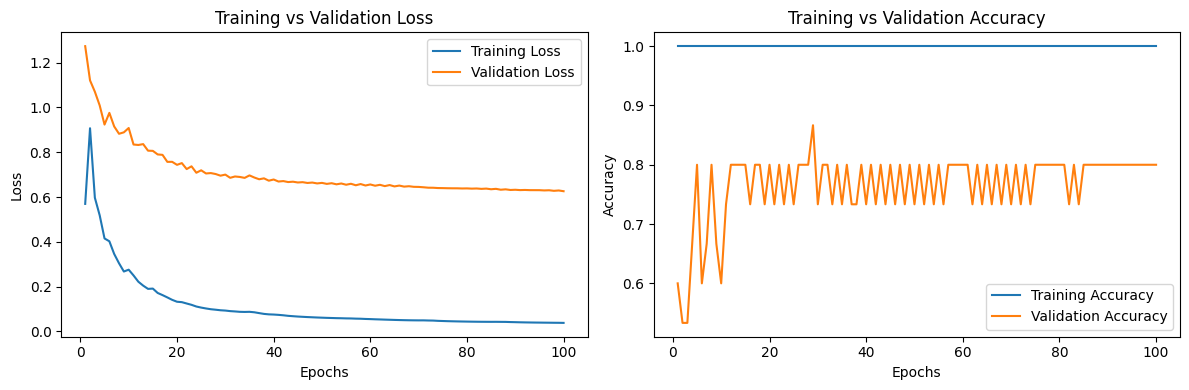

In [25]:
training_loss_vis(train_losses, val_losses, train_accuracies, val_accuracies)

In [26]:
test_losses, test_accuracies = test_model(model, classification_head, test_loader)

2 GPUs!


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s, loss=0.775]

Test Loss: 0.6483, Test Accuracy: 0.7833
